In [9]:
import pandas as pd
import pickle
import numpy as np
import dissertation.tools.utils as utils
import librosa
import matplotlib.pyplot as plt
import subprocess
from keras.models import model_from_json
from skimage.transform import resize
from speech2ult.tools.tal_io import read_ultrasound_tuple
from speech2ult.tools.transform_ultrasound import transform_ultrasound


In [10]:
# paths
ult_dict_path = 'speech2ult/predictions/ffn_dlc_ult/data/ULT_ffn_dlc_ult_2022-07-22.pickle'
aud_dict_path = 'speech2ult/predictions/ffn_dlc_ult/data/AUD_ffn_dlc_ult_2022-07-22.pickle'
dlc_data = 'speech2ult/predictions/test_data/day2_226_aud_ultDLC_mobnet_100_SpeechProductionFeb12shuffle1_800000.csv'
ult_path = 'speech2ult/predictions/test_data/226_aud.ult'
dlc_model = 'speech2ult/predictions/ffn_dlc_ult/model/DNN_ffn_dlc_ult_2022-07-22_model.json'
save_dir = 'speech2ult/project_code/predictions/ffn_dlc_ult/plots/test'

In [11]:
def clean_data(data):
    """Clean the dlc pandas dataset and return np array of features"""
    body_parts = data.loc['bodyparts'].values + '_' + data.loc['coords'].values
    data.columns = body_parts
    data.drop(index=['bodyparts', 'coords'], inplace=True)
    del_col = [col for col in data.columns if col.endswith('likelihood')]
    data.drop(columns=del_col, inplace=True)

In [12]:
def resize_ult(ult, n_scan, n_echo):
    """
    resize the ult to new size n_scan x n_echo. adapted from ultrasuite tools core.py
    :return: ult
    """

    resized = []
    for i, image in enumerate(ult):
        temp = resize(image, output_shape=(n_scan, n_echo), order=0, mode='reflect', clip=False,
                      preserve_range=True, anti_aliasing=False)
        temp = temp.round().astype(int)
        resized.append(temp)

    ult = np.array(resized)
    return ult

In [13]:
def load_ult(file):
    """load, downsample and resize ultrasound, returned with the sync offset in seconds"""
    ult, param_file = read_ultrasound_tuple(file, shape='3d', cast=None, truncate=None)
    offset = param_file['TimeInSecsOfFirstFrame']
    # current n_frames * target_fps/current_fps
    target_frames = int(ult.shape[0] * 60 / param_file['FramesPerSec'])
    ult = utils.resize(ult, target_frames)
    # resize dimensions
    ult = resize_ult(ult, 64, 128)
    return ult, offset

In [14]:
def apply_sync(ult, ult_fps, wav, wav_sr):
    """all should be aligned at begining, need to trim the ends and return"""

    ult_dur = ult.shape[0] / ult_fps
    wav_dur = wav.shape[0] / wav_sr
    lips_dur = float('inf')

    min_sec = np.min((ult_dur, wav_dur, lips_dur))
    ult_end = int(round(ult_fps * min_sec))
    wav_end = int(round(wav_sr * min_sec))

    return ult[:ult_end], wav[:wav_end]

In [15]:
def get_aud_feats(wav, params):
    """get the audio features from a loaded wav, return as (frames, features)"""
    n_mfcc = params['n_feat']//2 if params["deltas"] else params['n_feat']
    mfccs = librosa.feature.mfcc(
        y=wav,
        sr=params['sr'],
        n_mfcc=n_mfcc,
        hop_length=params['win_shift'],
        n_fft=params['win_len']
    )
    if params['deltas']:
        deltas = librosa.feature.delta(mfccs)
        feats = np.concatenate((mfccs,deltas))
        return feats.T
    else:
        return mfccs.T

In [16]:
# load in dlc_ult and aud dict for scalar?
with open(ult_dict_path, 'rb') as file:
    ult_dict, ult_params = pickle.load(file)

with open(aud_dict_path, 'rb') as file:
    aud_dict, aud_params = pickle.load(file)

# load original dlc data, and clean it
dlc_ult = pd.read_csv(dlc_data, index_col=0)
clean_data(dlc_ult)

# load original ult
ult, offset = load_ult(ult_path[:-4])

# make sure ult and dlc have same n_frames
if ult.shape[0] != dlc_ult.shape[0]:
    ult = ult[:dlc_ult.shape[0]]

# load audio
wav, sr = librosa.load(ult_path[:-4] + '.wav', offset=offset, sr=20000)

# sync
ult, wav = apply_sync(ult, 60, wav, sr)

# get aud_features
aud_features = get_aud_feats(wav, aud_params)

# normalize
dlc_ult_norm = ult_params['scalar'].transform(dlc_ult.values)
aud_features = aud_params['scalar'].transform(aud_features)

In [17]:
dlc_ult.columns

Index(['vallecula_x', 'vallecula_y', 'tongueRoot1_x', 'tongueRoot1_y',
       'tongueRoot2_x', 'tongueRoot2_y', 'tongueBody1_x', 'tongueBody1_y',
       'tongueBody2_x', 'tongueBody2_y', 'tongueDorsum1_x', 'tongueDorsum1_y',
       'tongueDorsum2_x', 'tongueDorsum2_y', 'tongueBlade1_x',
       'tongueBlade1_y', 'tongueBlade2_x', 'tongueBlade2_y', 'tongueTip1_x',
       'tongueTip1_y', 'tongueTip2_x', 'tongueTip2_y', 'hyoid_x', 'hyoid_y',
       'mandible_x', 'mandible_y', 'shortTendon_x', 'shortTendon_y'],
      dtype='object')

In [144]:
if aud_features.shape[0] != dlc_ult_norm.shape[0]:
    min_f = np.min((aud_features.shape[0], dlc_ult_norm.shape[0]))
    aud_features=aud_features[:min_f]
    dlc_ult_norm=dlc_ult_norm[:min_f]
dlc_true = dlc_ult.values[:min_f]
dlc_true = dlc_true.astype(float)

In [145]:
# load dlc model
model_weights = dlc_model[:-10] + 'weights.h5'
with open(dlc_model, "r") as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
# load weight into model
model.load_weights(model_weights)
model.compile(loss='mean_squared_error', optimizer='adam')

# use aud_features to predict dlc output
pred_dlc = model.predict(aud_features, verbose=0)

# plot true vs pred
col_names = dlc_ult.columns

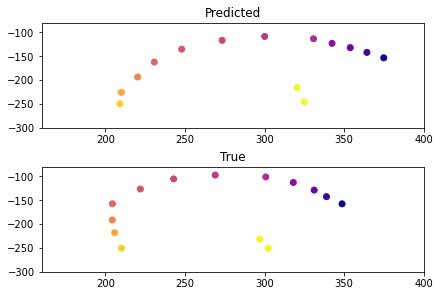

In [117]:
# try plotting each frame of dlc
def dlc_frame(pred, true, frame, dir):

    fig, ax = plt.subplots(nrows=2, layout='constrained')
    colors = np.array([80, 70, 60, 55, 50, 45, 40, 30, 20, 10, 0, 90, 100, 100])

    ax[0].scatter(pred[frame, :, 0], -pred[frame, :, 1], c=colors, cmap='plasma')
    ax[1].scatter(true[frame, :, 0], -true[frame, :, 1], c=colors, cmap='plasma')

    ax[0].set_title('Predicted')
    ax[1].set_title('True')

    ax[0].set_xlim([160, 400])
    ax[0].set_ylim([-300, -80])

    ax[1].set_xlim([160, 400])
    ax[1].set_ylim([-300, -80])

    plt.savefig(dir + "/%07d.jpg" % frame)

dlc_frame(pred_xy, true_xy, 100, save_dir)

In [146]:
pred_xy = ult_params['scalar'].inverse_transform(pred_dlc)
pred_xy = pred_xy.reshape((-1, 14, 2))
# true_xy = ult_params['scalar'].inverse_transform(dlc_ult_norm)
true_xy = dlc_true.reshape((-1, 14, 2))

# find min max values to know scale
pred_max_x = np.max(pred_xy[:, :, 0])
true_max_x = np.max(true_xy[:, :, 0])
max_x = np.max((pred_max_x, true_max_x))

pred_max_y = np.max(pred_xy[:, :, 1])
true_max_y = np.max(true_xy[:, :, 1])
max_y = np.max((pred_max_y, true_max_y))

pred_min_x = np.min(pred_xy[:, :, 0])
true_min_x = np.min(true_xy[:, :, 0])
min_x = np.min((pred_min_x, true_min_x))

pred_min_y = np.min(pred_xy[:, :, 1])
true_min_y = np.min(true_xy[:, :, 1])
min_y = np.min((pred_min_y, true_min_y))

print(f'max_x: {max_x} \nmax_y{max_y} \nmin_x{min_x}\nmin_y{min_y}')


max_x: 394.3821716308594 
max_y296.60986328125 
min_x165.13316345214844
min_y85.13243865966797


In [125]:
def dlc_frame_all(pred, true, dir):

    fig, ax = plt.subplots(nrows=2, layout='constrained')
    colors = np.array([80, 70, 60, 55, 50, 45, 40, 30, 20, 10, 0, 90, 100, 100])

    for frame in range(pred.shape[0]):
        ax[0].set_title('Predicted')
        ax[1].set_title('True')

        ax[0].set_xlim([160, 400])
        ax[0].set_ylim([-300, -80])

        ax[1].set_xlim([160, 400])
        ax[1].set_ylim([-300, -80])

        ax[0].scatter(pred[frame, :, 0], -pred[frame, :, 1], c=colors, cmap='plasma')
        ax[1].scatter(true[frame, :, 0], -true[frame, :, 1], c=colors, cmap='plasma')
        plt.savefig(dir + "/%07d.jpg" % frame)
        ax[0].clear()
        ax[1].clear()



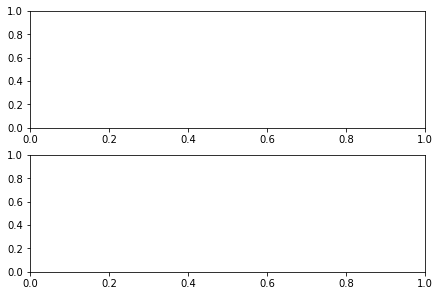

In [126]:
dlc_frame_all(pred_xy, true_xy, save_dir)

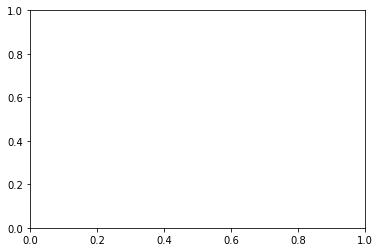

In [205]:
# save dlc position plots
fig, ax = plt.subplots()
for col in range(len(col_names)):
    ax.set_title(col_names[col])
    ax.set_xlabel('Time in frames (60fps)')
    ax.set_ylabel('Normalized position')
    xdata = np.arange(len(pred_dlc[:, col]))
    ax.plot(xdata, pred_dlc[:, col], label='Predicted')
    ax.plot(xdata, dlc_ult_norm[:, col], label='True')
    plt.axvline(x=86, color='r', label="Speech begins")
    ax.legend()
    plt.savefig(save_dir + f"/../dlc_plots/{col_names[col]}.jpg")
    ax.clear()


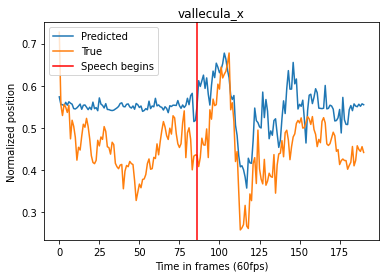

In [110]:
# for col in range(len(col_names)):
#      dlc_plot(pred_dlc[:, col], dlc_ult_norm[:, col], col_names[col])

In [36]:
# when does speech actually begin
from dissertation.tools.voice_activity_detection import detect_voice_activity
time_segments = detect_voice_activity(wav,sr)

In [37]:
print(time_segments)

[{'start': 0.0, 'stop': 0.03, 'is_speech': False}, {'start': 0.03, 'stop': 0.06, 'is_speech': False}, {'start': 0.06, 'stop': 0.09, 'is_speech': False}, {'start': 0.09, 'stop': 0.12, 'is_speech': False}, {'start': 0.12, 'stop': 0.15, 'is_speech': False}, {'start': 0.15, 'stop': 0.18, 'is_speech': False}, {'start': 0.18, 'stop': 0.21, 'is_speech': False}, {'start': 0.21, 'stop': 0.24, 'is_speech': False}, {'start': 0.24, 'stop': 0.27, 'is_speech': False}, {'start': 0.27, 'stop': 0.3, 'is_speech': False}, {'start': 0.3, 'stop': 0.33, 'is_speech': False}, {'start': 0.33, 'stop': 0.36, 'is_speech': False}, {'start': 0.36, 'stop': 0.39, 'is_speech': False}, {'start': 0.39, 'stop': 0.42, 'is_speech': False}, {'start': 0.42, 'stop': 0.45, 'is_speech': False}, {'start': 0.45, 'stop': 0.48, 'is_speech': False}, {'start': 0.48, 'stop': 0.51, 'is_speech': False}, {'start': 0.51, 'stop': 0.54, 'is_speech': False}, {'start': 0.54, 'stop': 0.57, 'is_speech': False}, {'start': 0.57, 'stop': 0.6, 'is_

In [38]:
1.44 * 60

86.39999999999999

In [148]:
subprocess.call(
        ["ffmpeg", "-y", "-r", "60",
         "-i", save_dir + "/%07d.jpg", "-vcodec", "mpeg4", "-qscale", "5", "-r",
         "60", "dlc_out.avi"])

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

0

In [162]:
# need to transfrom ultrasounds to real
ult_t = transform_ultrasound(ult, background_colour=255, num_scanlines=64,
                             size_scanline=128, angle=0.025,
                             zero_offset=30, pixels_per_mm=0.5)

# get rid of border
ult_t = ult_t[:, 50:-50, 10:-10]

In [165]:
# get dlc2ult
dlc2ult_path = '/Users/jacobrosen/Desktop/Edinburgh/Dissertation/project_code/predictions/dlc2ult_eval/model/dlc2ult_lips_test_2022-07-22_model.json'
# load model
model_weights_dlc2ult = dlc2ult_path[:-10] + 'weights.h5'
with open(dlc2ult_path, "r") as json_file:
    loaded_model_json = json_file.read()
dlc2ult_model = model_from_json(loaded_model_json)
# load weight into model
dlc2ult_model.load_weights(model_weights_dlc2ult)
dlc2ult_model.compile(loss='mean_squared_error', optimizer='adam')

# use aud_features to predict dlc output
pred_ult = dlc2ult_model.predict(pred_dlc, verbose=0)
pred_ult=pred_ult.reshape((-1, 64, 128))

In [171]:
# transform to real
pred_ult_t = transform_ultrasound(pred_ult, background_colour=1, num_scanlines=64,
                             size_scanline=128, angle=0.025,
                             zero_offset=30, pixels_per_mm=0.5)

# get rid of border
pred_ult_t = pred_ult_t[:, 50:-50, 10:-10]


In [187]:
ult_t.shape

(191, 532, 326)

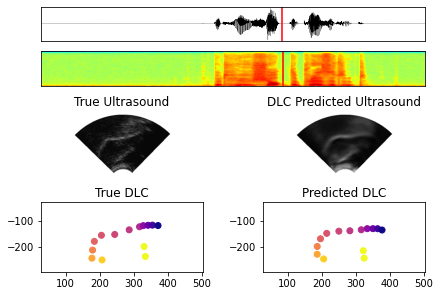

In [198]:
# single frame of spectrogram, true ult, dlc2ult, truedlc, predicted dlc
frame = 120
spectrogram_frame_size = 25
spectrogram_frame_shift = 10


grid = [['wav', 'wav'], ['spectrogram', 'spectrogram'], ['true_ult', 'dlc_ult'], ['true_ult', 'dlc_ult'], ['true_dlc', 'pred_dlc'], ['true_dlc', 'pred_dlc']]
fig, ax = plt.subplot_mosaic(grid, constrained_layout=True)
# titles
ax['pred_dlc'].set_title('Predicted DLC')
ax['true_dlc'].set_title('True DLC')
ax['true_ult'].set_title('True Ultrasound')
ax['dlc_ult'].set_title('DLC Predicted Ultrasound')

# plot the dlcs
colors = np.array([80, 70, 60, 55, 50, 45, 40, 30, 20, 10, 0, 90, 100, 100])
ax['pred_dlc'].scatter(pred_xy[frame, :, 0], -pred_xy[frame, :, 1], c=colors, cmap='plasma')
ax['true_dlc'].scatter(true_xy[frame, :, 0], -true_xy[frame, :, 1], c=colors, cmap='plasma')
# scaling
ax['pred_dlc'].set_xlim([29, 532-29])
ax['pred_dlc'].set_ylim([-326+29, -29])
ax['true_dlc'].set_xlim([29, 532-29])
ax['true_dlc'].set_ylim([-326+29, -29])

# plot true ult
ax['true_ult'].axis('off')
ax['true_ult'].imshow(ult_t[frame].T, aspect='equal', origin='lower', cmap='gray')

# plot dlc2ult
ax['dlc_ult'].axis('off')
ax['dlc_ult'].imshow(pred_ult_t[frame].T, aspect='equal', origin='lower', cmap='gray')

# plot wav
total_samples = wav.shape[0]
ax['wav'].plot(wav, color='black', linewidth=0.2)
ax['wav'].set_xlim([0, total_samples])
ax['wav'].set_xticks([])
ax['wav'].set_yticks([])
max_wav_x  = wav.shape[0]

# plot spectrogram
nfft = int(sr * (spectrogram_frame_size/1000.))
overlap = int(sr * (spectrogram_frame_shift/1000.))

# spectrogram with matplotlib:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html
spectrum, freqs, bins, spec_im = ax['spectrogram'].specgram(wav.reshape(-1,),\
    NFFT=nfft, Fs=sr, noverlap=overlap, cmap='jet')

spec_im.set_interpolation('bilinear')
ax['spectrogram'].set_xticks([])
ax['spectrogram'].set_yticks([])
xlim = ax['spectrogram'].get_xlim()
ax['spectrogram'].set_xlim([0, xlim[1]])
max_spec_x = xlim[-1]

#plot lines
wav_x = int( (1/60) * frame * sr)
wav_x = min(wav_x, max_wav_x)
ln1 = ax['wav'].axvline(x=wav_x, color='red')

spec_x = (1/60) * frame
spec_x = min(spec_x, max_spec_x)
ln2 = ax['spectrogram'].axvline(x=spec_x, color='red')

# plt.savefig(save_dir + "/../test2/%07d.jpg" % frame, dpi=200)

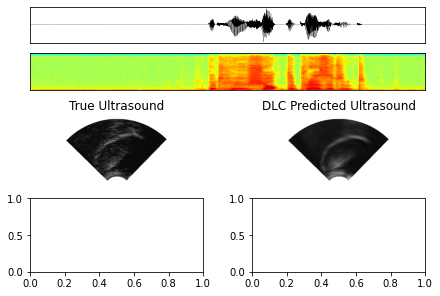

In [199]:
spectrogram_frame_size = 25
spectrogram_frame_shift = 10
colors = np.array([80, 70, 60, 55, 50, 45, 40, 30, 20, 10, 0, 90, 100, 100])

grid = [['wav', 'wav'], ['spectrogram', 'spectrogram'], ['true_ult', 'dlc_ult'], ['true_ult', 'dlc_ult'], ['true_dlc', 'pred_dlc'], ['true_dlc', 'pred_dlc']]
fig, ax = plt.subplot_mosaic(grid, constrained_layout=True)

# plot wav
total_samples = wav.shape[0]
ax['wav'].plot(wav, color='black', linewidth=0.2)
ax['wav'].set_xlim([0, total_samples])
ax['wav'].set_xticks([])
ax['wav'].set_yticks([])
max_wav_x  = wav.shape[0]

# plot spectrogram
nfft = int(sr * (spectrogram_frame_size/1000.))
overlap = int(sr * (spectrogram_frame_shift/1000.))

# spectrogram with matplotlib:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html
spectrum, freqs, bins, spec_im = ax['spectrogram'].specgram(wav.reshape(-1,),\
    NFFT=nfft, Fs=sr, noverlap=overlap, cmap='jet')

spec_im.set_interpolation('bilinear')
ax['spectrogram'].set_xticks([])
ax['spectrogram'].set_yticks([])
xlim = ax['spectrogram'].get_xlim()
ax['spectrogram'].set_xlim([0, xlim[1]])
max_spec_x = xlim[-1]

# set ult frames
dlc_im = ax['dlc_ult'].imshow(pred_ult_t[0].T, aspect='equal', origin='lower', cmap='gray')
true_im = ax['true_ult'].imshow(ult_t[0].T, aspect='equal', origin='lower', cmap='gray')

for frame in range(ult_t.shape[0]):
    # titles
    ax['pred_dlc'].set_title('Predicted DLC')
    ax['true_dlc'].set_title('True DLC')
    ax['true_ult'].set_title('True Ultrasound')
    ax['dlc_ult'].set_title('DLC Predicted Ultrasound')

    #plot lines
    wav_x = int( (1/60) * frame * sr)
    wav_x = min(wav_x, max_wav_x)
    ln1 = ax['wav'].axvline(x=wav_x, color='red')

    spec_x = (1/60) * frame
    spec_x = min(spec_x, max_spec_x)
    ln2 = ax['spectrogram'].axvline(x=spec_x, color='red')

    # plot the dlcs
    ax['pred_dlc'].scatter(pred_xy[frame, :, 0], -pred_xy[frame, :, 1], c=colors, cmap='plasma')
    ax['true_dlc'].scatter(true_xy[frame, :, 0], -true_xy[frame, :, 1], c=colors, cmap='plasma')
    # scaling
    ax['pred_dlc'].set_xlim([29, 532-29])
    ax['pred_dlc'].set_ylim([-326+29, -29])
    ax['true_dlc'].set_xlim([29, 532-29])
    ax['true_dlc'].set_ylim([-326+29, -29])

    # plot true ult
    ax['true_ult'].axis('off')
    true_im.set_data(ult_t[frame].T)

    # plot dlc2ult
    ax['dlc_ult'].axis('off')
    dlc_im.set_data(pred_ult_t[frame].T)

    plt.savefig(save_dir + "/../test2/%07d.jpg" % frame, dpi=150)

    # clear lines and dlc plots
    ln2.remove()
    ln1.remove()
    ax['pred_dlc'].clear()
    ax['true_dlc'].clear()


In [200]:
subprocess.call(
        ["ffmpeg", "-y", "-r", "60",
         "-i", save_dir + "/../test2/%07d.jpg", "-vcodec", "mpeg4", "-qscale", "5", "-r",
         "60", save_dir + "/../test2/temp.avi"])

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

0

In [203]:
import soundfile as sf
sf.write(save_dir+'/../sync_aud.wav', wav, sr)

In [204]:
# append aud and vid
subprocess.call(
        ["ffmpeg",
         "-i", save_dir+'/../sync_aud.wav',
         "-i", save_dir + "/../test2/temp.avi",
         "-codec", "copy", "-shortest", save_dir + "/../test2/full.avi"])

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

0

In [213]:
ult_params['scalar'].data_max_ - ult_params['scalar'].data_min_

array([108.19015503, 156.26075745, 287.42842865, 191.74766541,
       382.99617767, 198.74169922, 362.47177124, 196.04856873,
       357.04100037, 193.18057251, 342.11402893, 198.86875916,
       333.75204468, 215.11698532, 308.98843384, 211.20785141,
       315.89439392, 212.71627808, 335.59474182, 211.45114899,
       392.57266235, 228.9561882 , 290.77894592, 103.23683167,
       436.41939545, 252.50393677, 422.1102562 , 177.9699707 ])

In [210]:
col_names

Index(['vallecula_x', 'vallecula_y', 'tongueRoot1_x', 'tongueRoot1_y',
       'tongueRoot2_x', 'tongueRoot2_y', 'tongueBody1_x', 'tongueBody1_y',
       'tongueBody2_x', 'tongueBody2_y', 'tongueDorsum1_x', 'tongueDorsum1_y',
       'tongueDorsum2_x', 'tongueDorsum2_y', 'tongueBlade1_x',
       'tongueBlade1_y', 'tongueBlade2_x', 'tongueBlade2_y', 'tongueTip1_x',
       'tongueTip1_y', 'tongueTip2_x', 'tongueTip2_y', 'hyoid_x', 'hyoid_y',
       'mandible_x', 'mandible_y', 'shortTendon_x', 'shortTendon_y'],
      dtype='object')

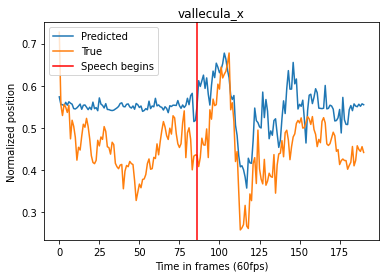

In [216]:
# single plot
fig, ax = plt.subplots()
col = 0
ax.set_title(col_names[col])
ax.set_xlabel('Time in frames (60fps)')
ax.set_ylabel('Normalized position')
xdata = np.arange(len(pred_dlc[:, col]))
ax.plot(xdata, pred_dlc[:, col], label='Predicted')
ax.plot(xdata, dlc_ult_norm[:, col], label='True')
plt.axvline(x=86, color='r', label="Speech begins")
ax.legend()

In [217]:
import scipy

In [267]:

def dlc_plot_one(true, pred, col):
    fig, ax = plt.subplots()
    ax.set_title(col_names[col])
    ax.set_xlabel('Time in frames (60fps)')
    ax.set_ylabel('Normalized position')
    xdata = np.arange(len(pred[:, col]))
    ax.plot(xdata, true[:, col], label='true')
    ax.plot(xdata, pred[:, col], label='pred')
    plt.axvline(x=86, color='r', label="Speech begins")
    ax.legend()


In [277]:
# median filter
filtered_dlc = np.empty_like(dlc_ult_norm)
for col in range(len(col_names)):
    filtered_dlc[:, col] = scipy.signal.medfilt(dlc_ult_norm[:, col], 7)

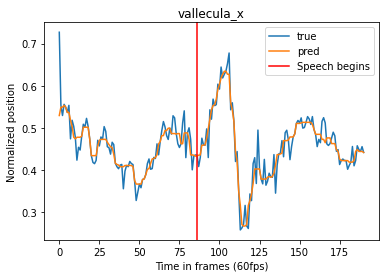

In [287]:
dlc_plot_one(dlc_ult_norm, filtered_dlc, 0)

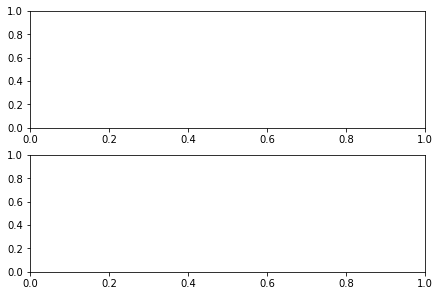

In [280]:
filtered_xy = ult_params['scalar'].inverse_transform(filtered_dlc)
filtered_xy = filtered_xy.reshape(-1, 14, 2)
dlc_frame_all(filtered_xy, true_xy, save_dir + '/../filtered')

In [281]:
subprocess.call(
        ["ffmpeg", "-y", "-r", "60",
         "-i", save_dir + "/../filtered/%07d.jpg", "-vcodec", "mpeg4", "-qscale", "5", "-r",
         "60", save_dir + "/../filtered/filter_test.avi"])

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 6.1.0 (clang-602.0.53) (based on LLVM 3.6.0svn)
  configuration: --prefix=/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/Users/travis/miniconda3/conda-bld/ffmpeg_1510333912089/_b_env_placehold_placehold_placehold_placehold_placehold_place

0

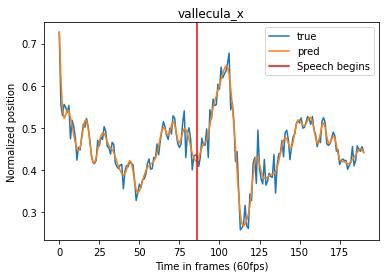

In [299]:
# butter filter
fc = 10  # Cut-off frequency of the filter
w = fc / (60 / 2) # Normalize the frequency
b, a = scipy.signal.butter(5, w, 'low')

butter_dlc = np.empty_like(dlc_ult_norm)
for col in range(len(col_names)):
    butter_dlc[:, col] = scipy.signal.filtfilt(b, a, dlc_ult_norm[:, col])

dlc_plot_one(dlc_ult_norm, butter_dlc, 0)

In [309]:
# butter then median
filtx2 = np.empty_like(dlc_ult_norm)
for col in range(len(col_names)):
    filtx2[:, col] = scipy.signal.medfilt(butter_dlc[:, col], 7)

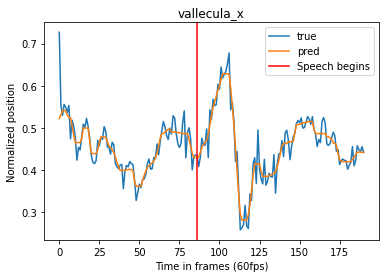

In [313]:
dlc_plot_one(dlc_ult_norm, filtx2, 0)

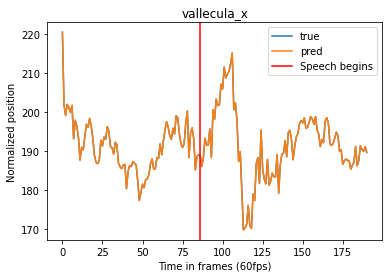

In [308]:
dlc_plot_one(dlc_true, dlc_true, 0)